## Threshold change

In [3]:
# import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
plt.style.use('ggplot') 

In [2]:
train= pd.read_csv('Train_v2.csv')

In [4]:
#load data
le = LabelEncoder()
def load_data(data, s_attr):
    X= data.drop(['bank_account','uniqueid'],axis=1)
    Y= data['bank_account']
    Y=pd.Series([0 if x=='No' else 1 for x in Y])
    categorical_feature_mask = X.dtypes==object
    categorical_cols = X.columns[categorical_feature_mask].tolist()
    X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
    Z = X.loc[:, s_attr]
#     X= X.drop([s_attr],axis=1)
    return X, Y, Z

In [5]:
X, Y,Z= load_data(train,'gender_of_respondent')

In [47]:
# split data
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, Y, Z, 
                                                                     test_size=0.45,random_state=7542) 

In [48]:
K1=[]
#varying the threshold
models=[LogisticRegression(),
        RandomForestClassifier(n_estimators=100, oob_score=True, random_state=12),
        DecisionTreeClassifier(random_state = 21),MLPClassifier()]
for model in models:
    clf = model
    clf.fit(X_train, y_train)
    K=[]
    for i in np.arange(0.1,1,0.1):
        THRESHOLD = i
        preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
        D = Get_fair_metric(model,preds,y_test,Z_test)
        K.append(D)
    K1.append(K)

/home/students/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [50]:
#split classifier
a=pd.DataFrame(K1[0])
b=pd.DataFrame(K1[1])
c=pd.DataFrame(K1[2])
d=pd.DataFrame(K1[3])

In [55]:
#visualize
a.T

,0,1,2,3,4,5,6,7,8
model,"LogisticRegression(C=1.0, class_weight=None, d...","LogisticRegression(C=1.0, class_weight=None, d...","LogisticRegression(C=1.0, class_weight=None, d...","LogisticRegression(C=1.0, class_weight=None, d...","LogisticRegression(C=1.0, class_weight=None, d...","LogisticRegression(C=1.0, class_weight=None, d...","LogisticRegression(C=1.0, class_weight=None, d...","LogisticRegression(C=1.0, class_weight=None, d...","LogisticRegression(C=1.0, class_weight=None, d..."
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Demographic Parity,0.180637,0.122783,0.105002,0.0608255,0.0447135,0.0232832,0.0112266,0.00995892,0.00165868
Disparate Impact,0.941331,0.821457,0.634921,0.661914,0.609467,0.719212,0.860656,0.507463,0.4
Equalised_opportunity,-0.0618755,-0.0686532,-0.132423,-0.084584,-0.083124,-0.0389015,0.00272945,-0.0186978,-0.00510496
Equalised_odds,-0.16165,-0.0895128,-0.0644645,-0.0291877,-0.0184601,-0.00785624,-0.00574881,-0.00458766,-0.000391086
Treatment equality,1.06522,1.08663,1.54567,1.27836,1.28149,0.925227,0.914129,1.74242,1.64286
Predictive equality,0.16165,0.0895128,0.0644645,0.0291877,0.0184601,0.00785624,0.00574881,0.00458766,0.000391086
Conditional Use Accuracy,-0.0253,-0.00544686,0.0165037,0.0204961,0.00510431,-0.0209561,0.0666917,0.0995659,0.0329543
Overall Use Accuracy,0.0997749,0.0208596,-0.0679581,-0.0553964,-0.0646639,-0.0310452,0.00847826,-0.0141101,-0.00471387


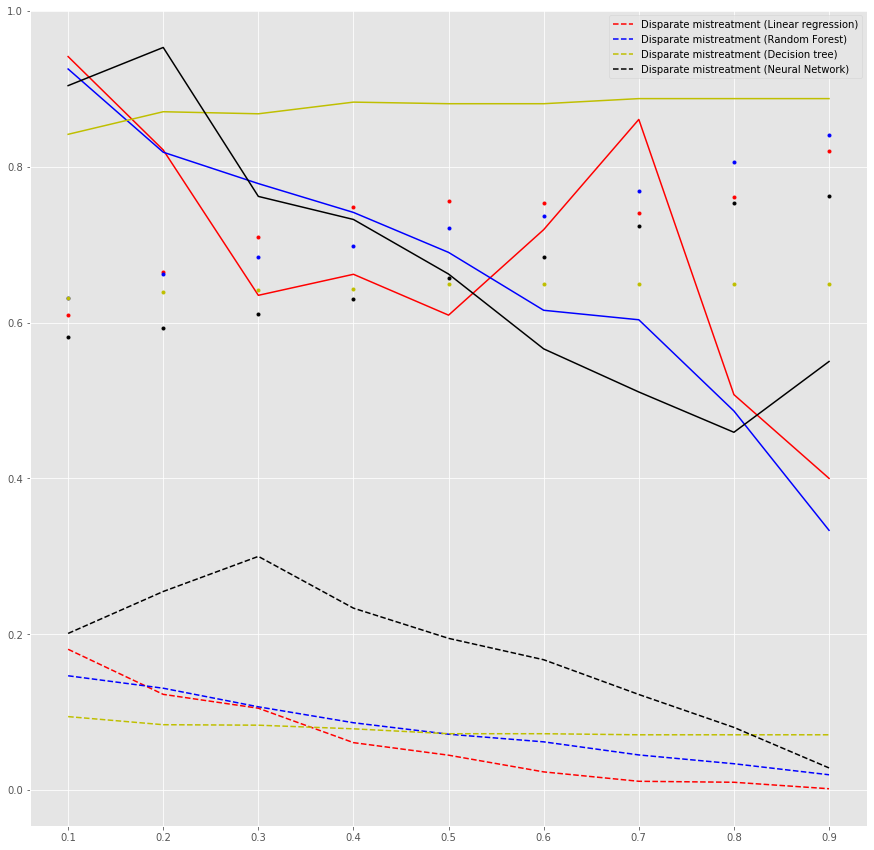

In [53]:
plt.figure(figsize=[15,15])
plt.plot(a['threshold'],a['Demographic Parity'],'--r',label='Disparate mistreatment (Linear regression)' )
plt.plot(b['threshold'],b['Demographic Parity'],'--b',label='Disparate mistreatment (Random Forest)' )
plt.plot(c['threshold'],c['Demographic Parity'],'--y',label='Disparate mistreatment (Decision tree)' )
plt.plot(d['threshold'],d['Demographic Parity'],'--k',label='Disparate mistreatment (Neural Network)' )

plt.plot(a['threshold'],a['Disparate Impact'],'r' )
plt.plot(b['threshold'],b['Disparate Impact'],'b' )
plt.plot(c['threshold'],c['Disparate Impact'],'y' )
plt.plot(d['threshold'],d['Disparate Impact'],'k' )

plt.plot(a['threshold'],a['roc_accuracy'],'.r' )
plt.plot(b['threshold'],b['roc_accuracy'],'.b' )
plt.plot(c['threshold'],c['roc_accuracy'],'.y' )
plt.plot(d['threshold'],d['roc_accuracy'],'.k' )
plt.legend()

In [41]:
#modified fair.py
def DP_accuracy (y_hat,A):
    A , y_hat = np.array(A).reshape(-1) , y_hat.reshape(-1)
    sum_A0 = 0
    sum_A1 = 0
    n_A1 = np.count_nonzero(A)
    n_A0 = len(A) - np.count_nonzero(A)
    for i in range (len(y_hat)):
        sum_A0 += y_hat[i]*(1-A[i])
        sum_A1 += y_hat[i]*A[i]
    accuracy= abs(sum_A0/n_A0 - sum_A1/n_A1)
    return accuracy

def p_rule(y_pred, z_values):
    y_z_1 =np.array([i for i,j in zip(y_pred,z_values) if i==1 and j==1])
    y_z_0 = np.array([i for i,j in zip(y_pred,z_values) if i==1 and j==0])
    odds = y_z_1.sum() / y_z_0.sum()
    return  np.min([odds, 1/odds]) 

def split(y_pred,y_test,z_test): 
    pred0 =np.array([i for i,j,k in zip(y_pred,y_test,z_test) if k==0])
    pred1 = np.array([i for i,j,k in zip(y_pred,y_test,z_test) if k==1])
    y_test0 =np.array([j for i,j,k in zip(y_pred,y_test,z_test) if k==0])
    y_test1 = np.array([j for i,j,k in zip(y_pred,y_test,z_test) if k==1])
    return [pred0,y_test0,pred1,y_test1]

def classreport(pred,y_test):
    
    fp = sum(np.logical_and(y_test == 0, pred == 1)) 
    fn = sum(np.logical_and(y_test == 1, pred == 0)) 
    tp = sum(np.logical_and(y_test == 1, pred == 1)) 
    tn = sum(np.logical_and(y_test== 0, pred == 0))
    
    fpr = float(fp) / float(fp + tn)
    fnr = float(fn) / float(fn + tp)
    tpr = float(tp) / float(tp + fn)
    tnr = float(tn) / float(tn + fp)
    npv = float(tn) / float(tn + fn)
    ppv = float(tp) / float(tp + fp)
    acc = (tp + tn) / (tp + tn + fp + fn)
    di= {'False Positive': fp,
         'False Negative': fn,
         'True Positive': tp,
         'True Negative': tn,
         'False Positive rate': fpr,
         'False Negative rate': fnr,
         'True Positive rate': tpr,
         'True Negative rate': tnr,
         'npv': npv,
         'ppv': ppv,
        }
    return di

def Get_fair_metric(model,y_pred,y_test,Z_test):
    pre1,y_test1 = split(y_pred,y_test,Z_test)[0],split(y_pred,y_test,Z_test)[1]
    pre2,y_test2 = split(y_pred,y_test,Z_test)[2],split(y_pred,y_test,Z_test)[3]
    a=classreport(pre1,y_test1)
    b=classreport(pre2,y_test2)
    dp= DP_accuracy (y_pred,Z_test)
    dI=p_rule(y_pred, Z_test)
    Equalised_opportunity= a['True Positive rate']- b['True Positive rate']
    Equalised_odds = a['False Positive rate']- b['False Positive rate']
    Treatmentequal= (b['False Positive']/b['False Negative'])/(a['False Positive']/a['False Negative'])
    Predictiveequal= a['True Negative rate']- b['True Negative rate']
    condUseAcc= (a['ppv']+a['npv'])- (b['ppv']+b['npv'])
    OVerUseAcc= (a['True Positive rate']+a['True Negative rate'])- (b['True Positive rate']+b['True Negative rate'])
    D={'model': model,'threshold':i,'Demographic Parity':dp, 'Disparate Impact':dI, 'Equalised_opportunity': Equalised_opportunity,
      'Equalised_odds': Equalised_odds, 'Treatment equality': Treatmentequal,
       'Predictive equality' : Predictiveequal, 'Conditional Use Accuracy': condUseAcc, 
      'Overall Use Accuracy': OVerUseAcc, 'roc_accuracy': roc_auc_score(y_pred,y_test)}
    return D